## BERT (Bidirectional Encoder Representation from Transformers)

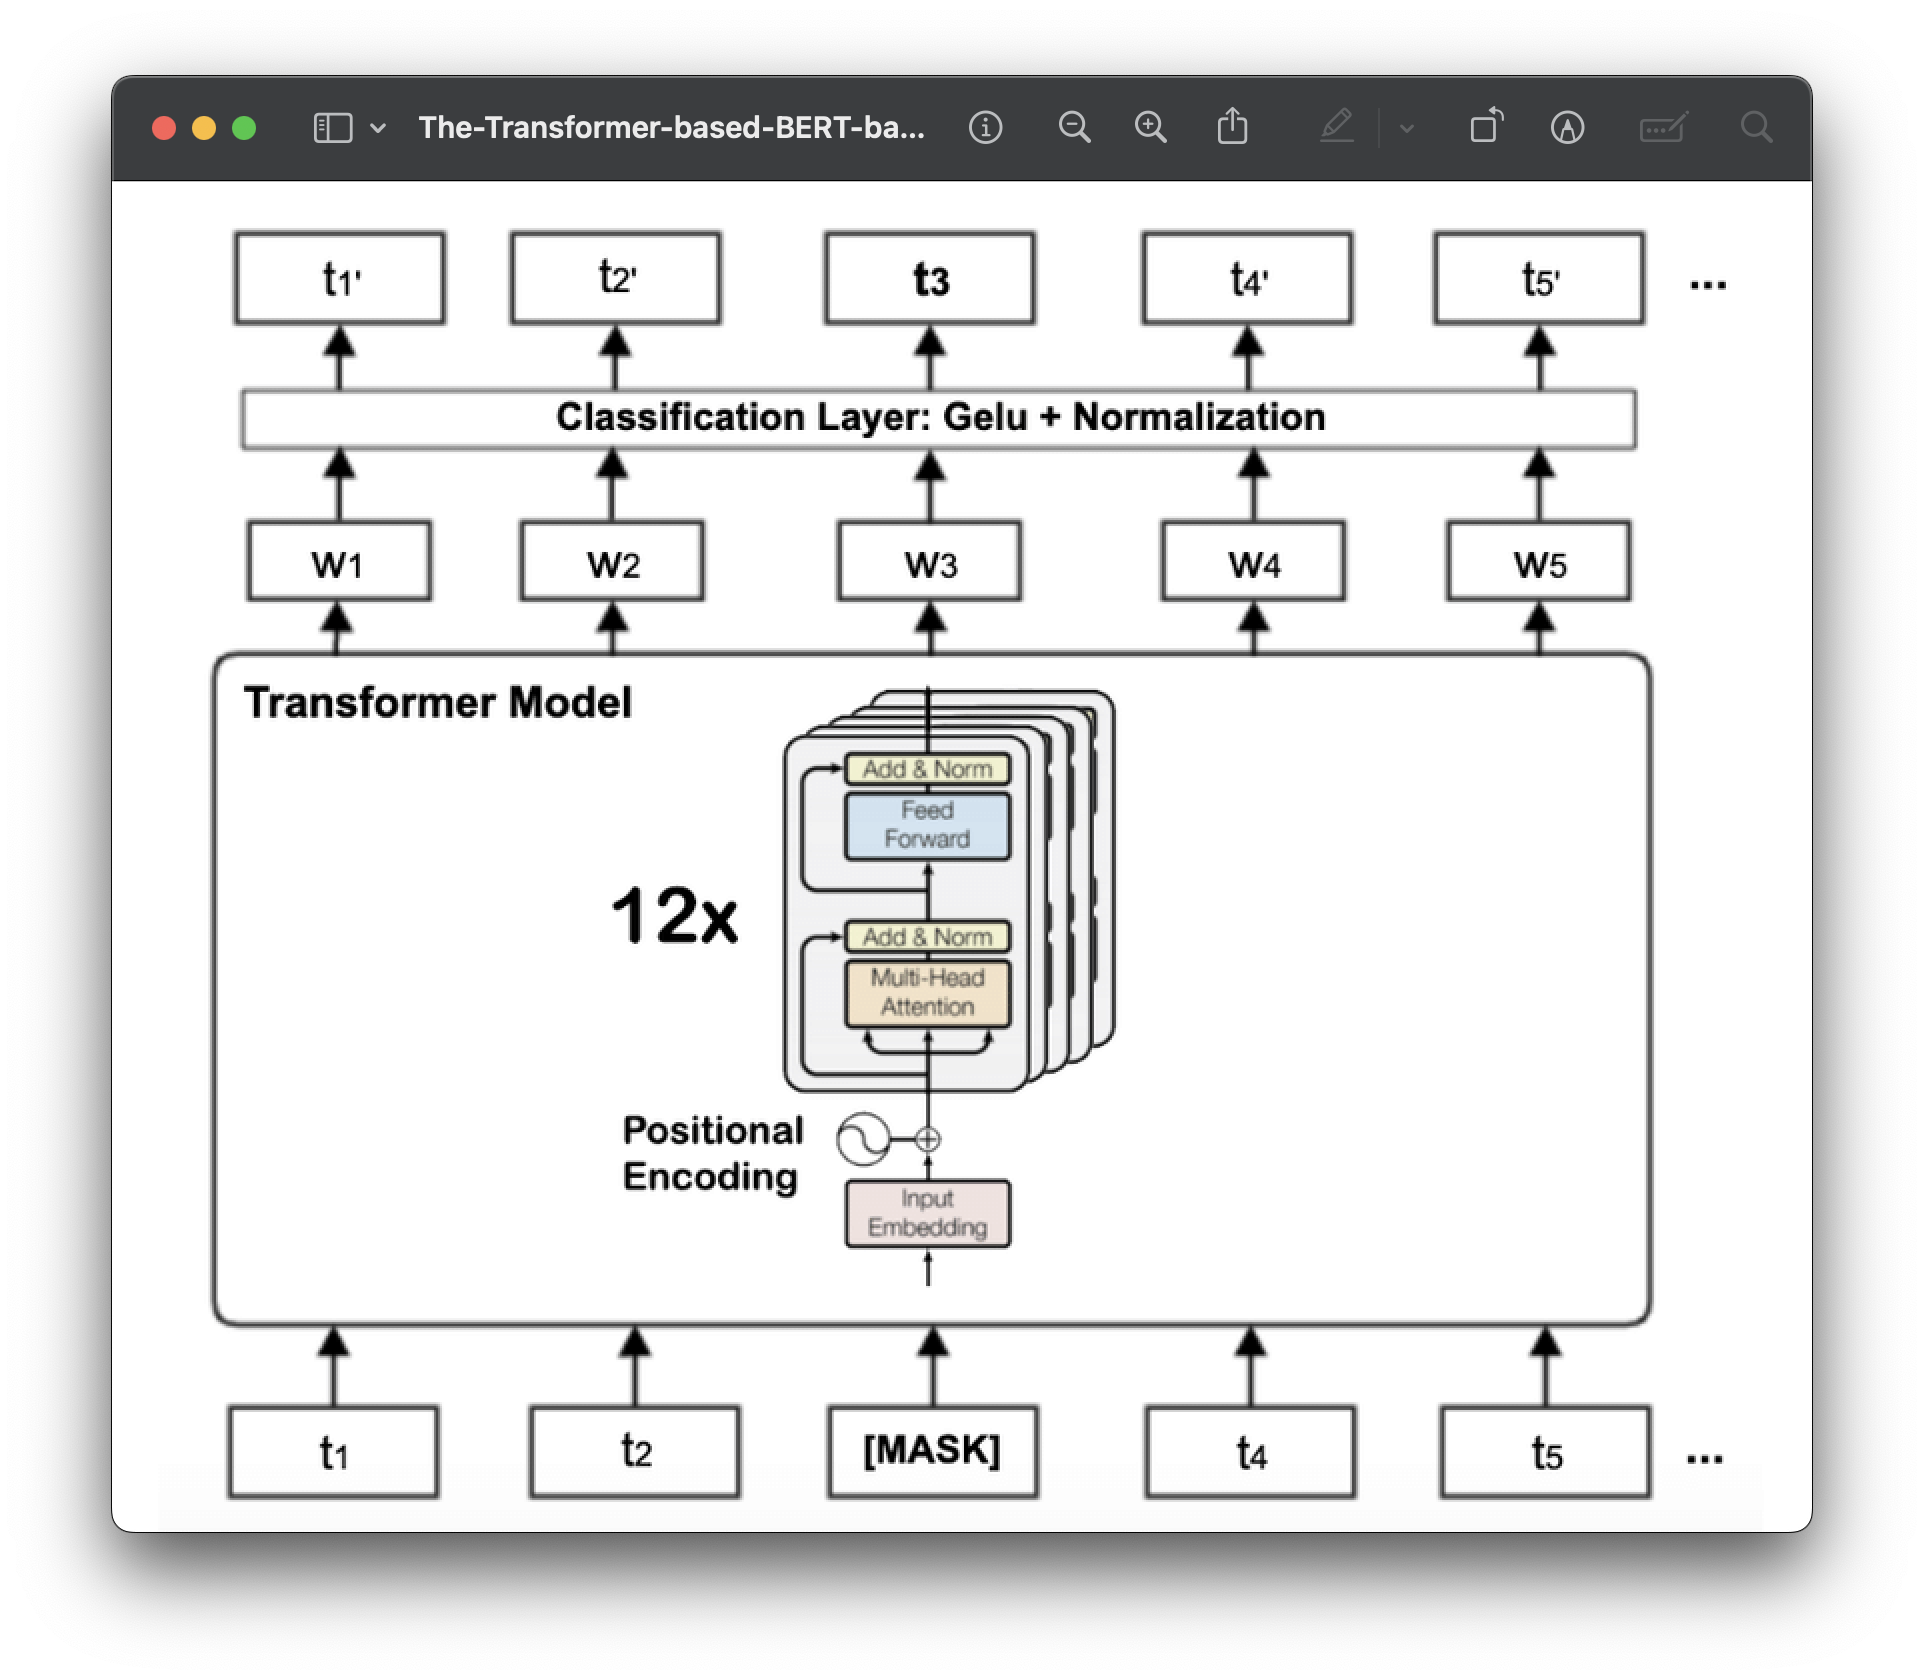

- Apa itu Attention (udah kamu kuasai feeling-nya 🔥)

- Bagaimana Attention dihitung (Query-Key-Value + hitungan kecil → lagi kita lakuin sekarang)

- Self-Attention di semua kata di kalimat (next step kita)

- Multi-Head Attention (kenapa pakai banyak Attention barengan?)

- Positional Encoding (gimana BERT tau urutan kata?) -> Learned Positional Embedding.

- Encoder Stack (BERT = tumpukan encoder, kayak kue lapis)

- Training Objective BERT (Masked Language Model + Next Sentence Prediction)

- Fine-Tuning (gimana BERT dipakai buat tugas kayak QA, Sentimen, dst.)

# SCALED DOT PRODUCT ATTENTION

# FULL STACK ENCODER

# PRETRAINING 

## MLM (MASKED LANGUAGE MODELLING)


## NSP (NEXT SENTENCE PREDICTION)

# FINE-TUNING

## Text Classification

In [ ]:
import torch
from datasets import load_dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer
)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pretrained model and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)  # Move model to appropriate device

# Load dataset
dataset = load_dataset("imdb", split="train[:2000]")
dataset = dataset.train_test_split(test_size=0.2)
print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

# Tokenize function - create a function that properly formats data
def tokenize_function(examples):
    # Return tokenized examples with proper padding and truncation
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512,  # Specify max_length explicitly
        return_tensors="pt"  # Return PyTorch tensors
    )

# Process dataset to have the right format and data types
tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]  # Remove text column which won't be needed
)

# Convert label column to make it compatible with the model
tokenized_datasets = tokenized_datasets.map(
    lambda examples: {"labels": examples["label"]},
    remove_columns=["label"]  # Remove original label column
)

# Check the structure of our processed dataset
print("\nSample from processed dataset:")
sample = tokenized_datasets["train"][0]
print(f"Type: {type(sample)}")
print(f"Keys: {sample.keys()}")
print(f"Example item: {sample}")

# Define training arguments
# Check the TrainingArguments available parameters
from inspect import signature
print("Available parameters for TrainingArguments:", signature(TrainingArguments))

training_args = TrainingArguments(
    output_dir="./results",
    # Try with no evaluation strategy parameter first
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    # Simplified arguments to minimize potential issues
    logging_dir="./logs"
)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
)

# Train model
print("\nStarting training...")
trainer.train()

# Evaluate model
print("\nEvaluating model...")
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

# Save model
model_path = "./imdb-bert-classifier"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"\nModel saved to {model_path}")

## SQuAD 

In [ ]:
from transformers import BertTokenizerFast, BertForQuestionAnswering
from transformers import Trainer, TrainingArguments
from datasets import load_dataset


model_name = "bert-base-uncased"

tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertForQuestionAnswering.from_pretrained(model_name)


dataset = load_dataset("squad", split="train[:1000]")
dataset = dataset.train_test_split(test_size=0.2)


def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    contexts = [c.strip() for c in examples["context"]]

    inputs = tokenizer(
        questions,
        contexts,
        max_length=384,
        truncation="only_second",
        padding="max_length",
        return_offsets_mapping=True,
        return_tensors="pt",
    )

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(inputs["offset_mapping"]):
        answer = examples["answers"][i]
        start_char = answer["answer_start"][0]
        end_char = start_char + len(answer["text"][0])

        sequence_ids = inputs.sequence_ids(i)

        context_start = sequence_ids.index(1)
        context_end = len(sequence_ids) - 1 - list(reversed(sequence_ids)).index(1)

        offsets = offsets[context_start:context_end+1]
        for idx, (start, end) in enumerate(offsets):
            if start <= start_char and end >= start_char:
                start_positions.append(idx + context_start)
            if start <= end_char and end >= end_char:
                end_positions.append(idx + context_start)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)


training_args = TrainingArguments(
    output_dir="./qa-results",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
)


trainer.train()

# Output

## HIDDEN STATE (HIDDEN OUTPUT)

## POOLER OUTPUT ([CLS])

| Output        | Bentuk                                       | Gunanya                                                                                  |
| :------------ | :------------------------------------------- | :--------------------------------------------------------------------------------------- |
| Hidden States | `(batch_size, sequence_length, hidden_size)` | Tiap token punya representasi kontekstual. Cocok buat tagging per token (NER, QA).       |
| Pooler Output | `(batch_size, hidden_size)`                  | Representasi seluruh kalimat. Cocok buat klasifikasi kalimat (Pos/Neg, Entailment, dst). |


# HYPERPARAMETER

| Hyperparameter | BERT Umum      | Kenapa              |
| -------------- | -------------- | ------------------- |
| Learning Rate  | 2e-5 atau 3e-5 | Supaya update halus |
| Batch Size     | 8 atau 16      | Supaya hemat memori |
| Epoch          | 2-4            | Cukup buat adaptasi |


# QA MANUALLY

- Masukin input ➔ dapat logits (start_logits, end_logits).

- Cari index paling tinggi dari start_logits ➔ itu awal jawaban.

- Cari index paling tinggi dari end_logits ➔ itu akhir jawaban.

- Potong token dari start sampai end ➔ decode jadi teks jawaban.



In [2]:
from transformers import BertTokenizerFast, BertForQuestionAnswering
import torch

# Load model
model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertForQuestionAnswering.from_pretrained(model_name)

# Input
context = "The capital city of France is Paris."
question = "What is the capital of France?"

# Tokenize
inputs = tokenizer(question, context, return_tensors="pt")

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)

start_logits = outputs.start_logits
end_logits = outputs.end_logits

# Get the highest scoring start and end token positions
start_index = torch.argmax(start_logits)
end_index = torch.argmax(end_logits)

# Decode the answer
answer_ids = inputs["input_ids"][0][start_index : end_index + 1]
answer = tokenizer.decode(answer_ids)

print(f"Predicted Answer: {answer}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted Answer: 


# MLM (MASKED LANGUAGE MODELLING)

In [3]:
from transformers import BertTokenizerFast, BertForMaskedLM
import torch

# Load model
model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)

# Text with mask
text = "The capital of [MASK] is Paris."

# Tokenize
inputs = tokenizer(text, return_tensors="pt")

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits

# Index of [MASK]
mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]

# Predicted token
predicted_token_id = logits[0, mask_token_index].argmax(axis=-1)
predicted_token = tokenizer.decode(predicted_token_id)

print(f"Predicted Token: {predicted_token}")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Predicted Token: france


# MINI BERT MANUALLY

## ARCHITECTURE

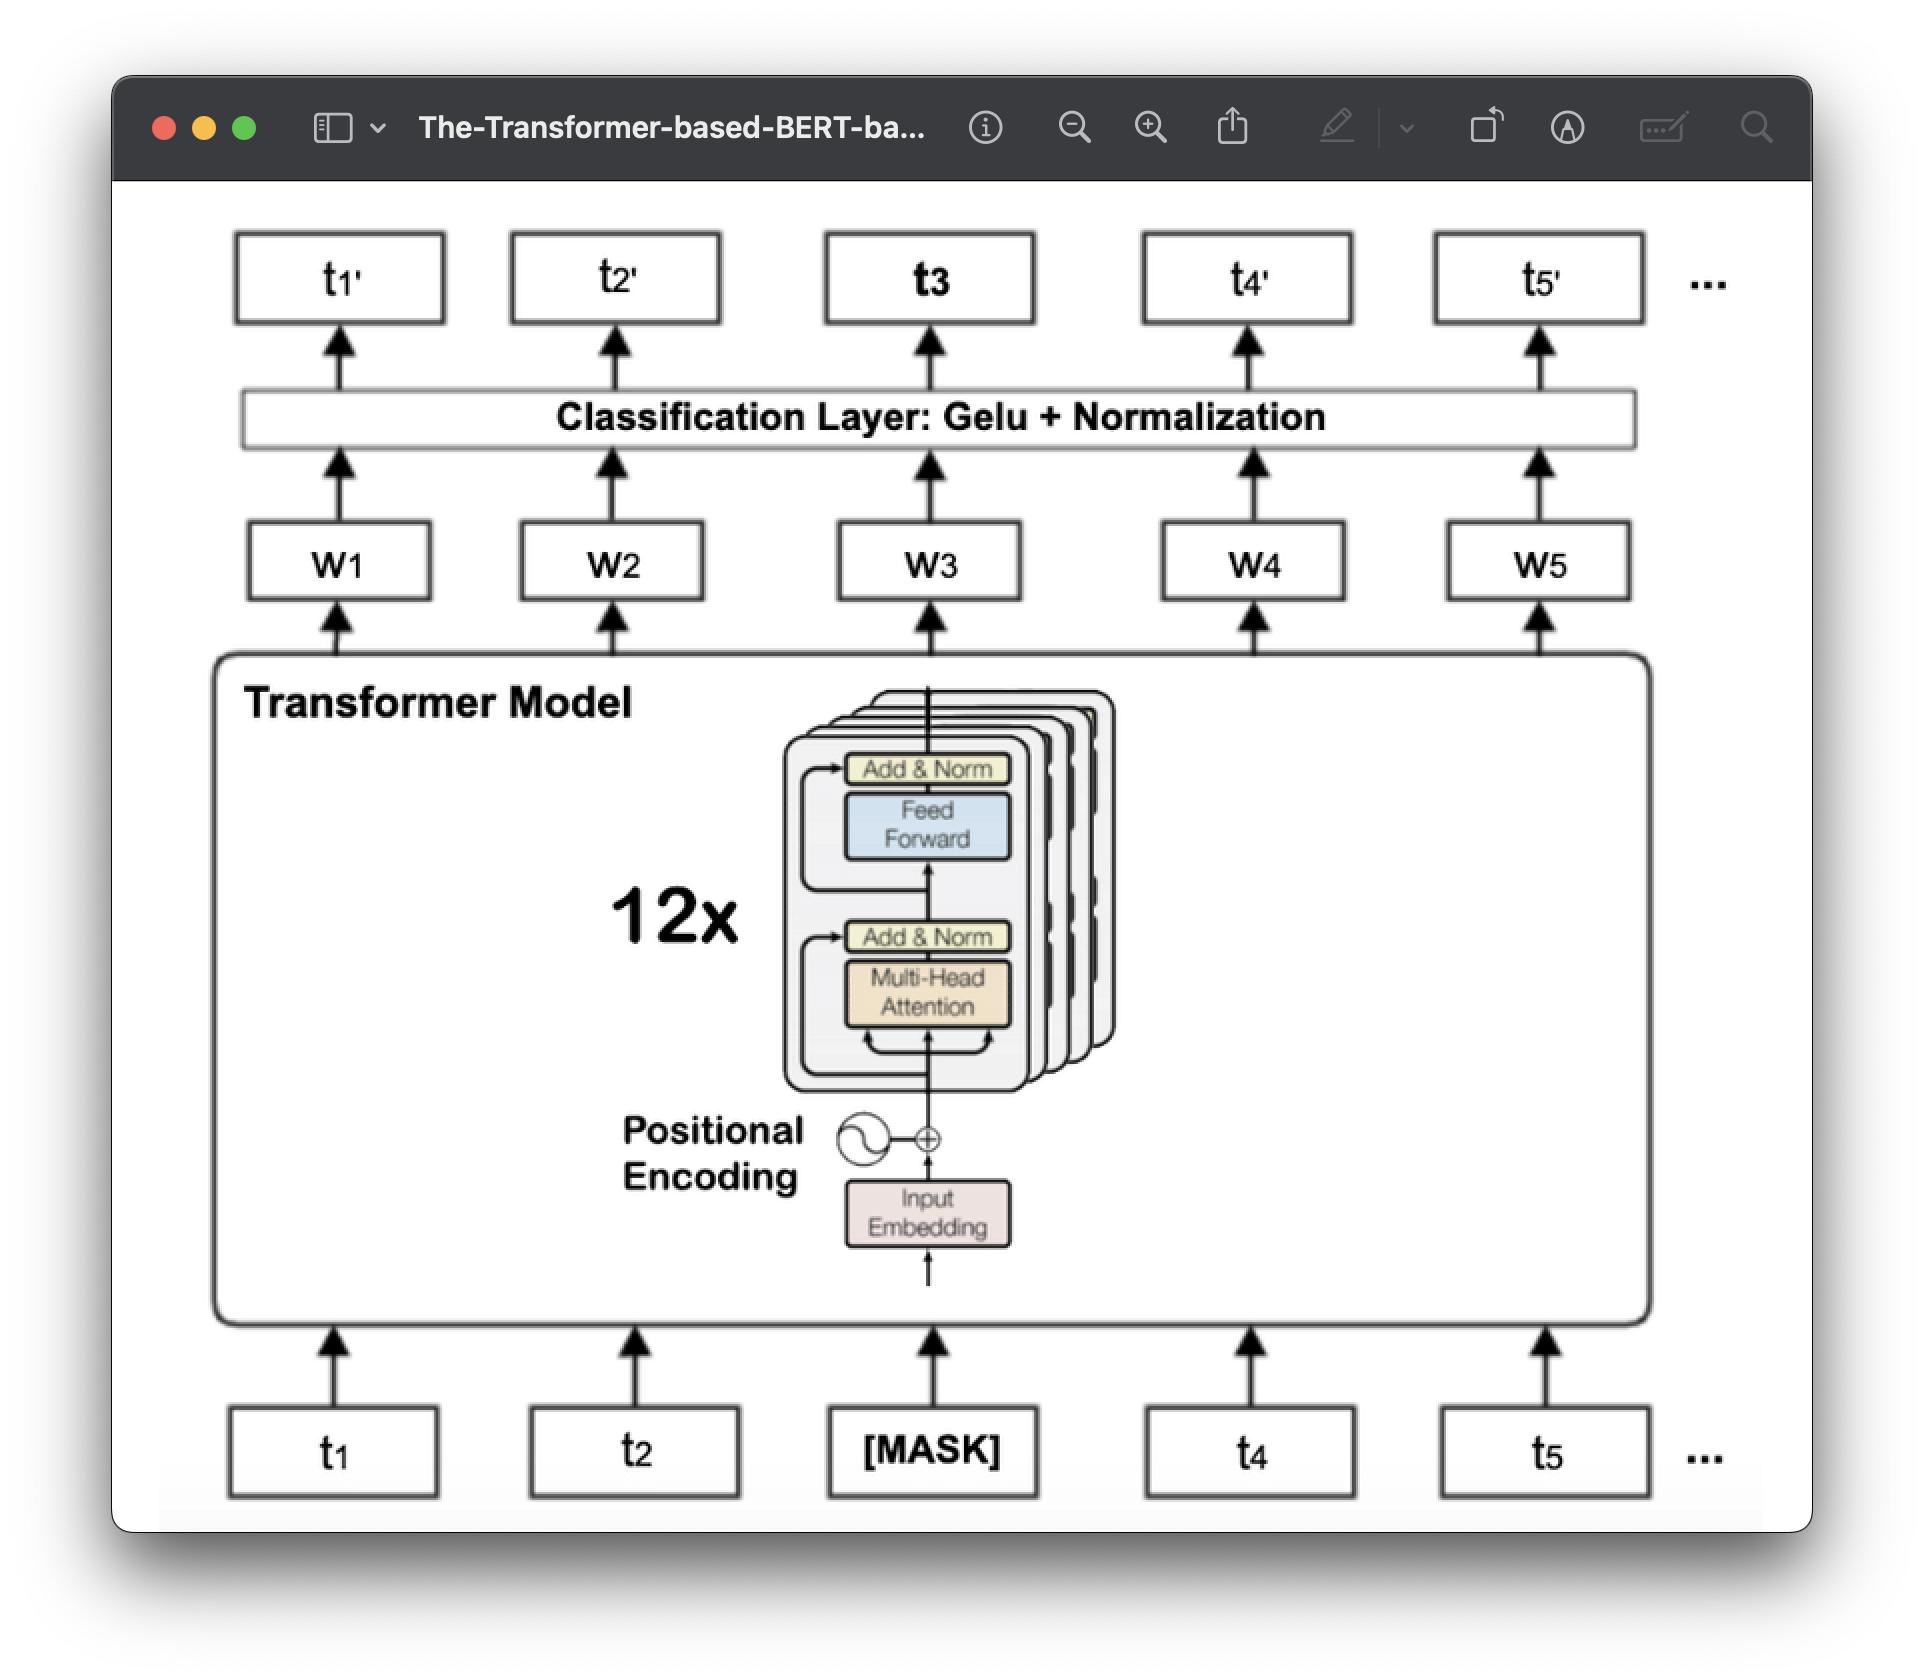


## INPUT DATA

## TOKENIZATION

- Transforming every word into token (int ID) using vocab

- WordPiece for BERT, for example :

- Kalimat: "cat eating fish"
- Tokenized → [11, 25, 38]
- Vocab → {1 : 11, 2 : 25, 3 : 38}


## POSITIONAL EMBEDDINGS

- every token will turn into vector representation + its position.

- step :

- word embedding lookup table n dimentional for every word

- positional encoding lookup table for every position word and add with embedding value.

- example :

- Word embed [128-d]

- Position embed [128-d]

- Add embed-position → we get [128-d] for every token.



## STACK ENCODER

#### SCALED DOT PRODUCT ATTENTION

- Multi head meaning every word has n perpective on how that word context is.

##### SELF ATTENTION

- every token look into another token and update its representation based on proporsition telling relationship.


- Step :

- Input Vector → Linear projection to Q, K, V.

- attention score softmax(QKᵀ / √d).

- mutiply score × V.

- Concacinate with another head

- Output: new hidden state that more "smart" - has more context.


#### RESIDUAL AND NORMALIZATION

- jaga info lama + stabilkan training.
- Tambahkan input + output Self-Attention ➔ Residual.
- Normalisasi hasilnya ➔ LayerNorm.
- attention_output = LayerNorm(input + attention(input))


#### FEED FORWARD

- Perbaiki representasi token secara individual.

- proses :

- expand → relu → shrink.

- Seleksi fitur-fitur penting per token.

- detail :

- Dense layer 1: expand dimensi (misal 128 ➔ 512).

- ReLU : buang informasi ga guna, fokus ke internal connection

- Dense layer 2: balik ke dimensi awal (512 ➔ 128).




#### RESIDUAL AND NORMALIZATION

- jaga info lama + stabilkan training.
- Tambahkan input + output Self-Attention ➔ Residual.
- Normalisasi hasilnya ➔ LayerNorm.
- attention_output = LayerNorm(input + attention(input))
- ffn_output = LayerNorm(attention_output + FFN(attention_output))


## ANOTHER ENCODER BLOCK

- input = ffn_output

- ....

-  ......

- 12 - 24X

## OUTPUT 


### HIDDEN STATE

- Hidden States	(batch_size, sequence_length, hidden_size)
- Tiap token punya representasi kontekstual.
- buat tagging per token (NER, QA).


### POOLED STATE

- Pooler Output (batch_size, hidden_size)
- Representasi seluruh kalimat.
- buat klasifikasi kalimat (Pos/Neg, Entailment, dst).

---

## PSEUDOCODE INPLEMENTATION

### INPUT
    ## input text or corpus
    
    c = "x y z ...."

### TOKEN

    # text into number by id or index
    
    t = [x_id, y_id, z_id, ...... , n_id]

### POSITIONAL EMBEDDING

    ## encode each token to embed and position
    
    for each token in t:
    
    embedding vector = word embedding matrix [token_id] -> vectorize the input token for each word
    positional vector = positional embeedin matrix [position] -> vector that tell what the order of each token by poition
    input that vectorized: input_vector = embedding vector + positional vector

    ## result:
    
    vectors  = [input_vector_1, input_vector_2, input_vector_3, ......., input_vector_n]




### STACK ENCODER - 2 LAYER

    ## for each encoder layer :

        ## if multihead self attention :
    
        for each token in t :
            linear projection 1, 2, 3 ...., n =  Q, K, V  from input vectors
        
        for each pair of token (i,j) : 
            attention score 1, 2, 3 ...., n = dot product (Q[i], K[j]) / sqrt (d_model = input vectors [-1])

        for each token i:
            normalize the value by softmax accross attention score
            attention output 1, 2, 3 ...., n= sum over j (softmax_score[i][j] * V[j])

            
        ## if self attention block

        for each token in t :
            linear projection =  Q, K, V  from input vectors
        
        for each pair of token (i,j) : 
            attention score = dot product (Q[i], K[j]) / sqrt (d_model = input vectors [-1])

        for each token i:
            normalize the value by softmax accross attention score
            attention output = sum over j (softmax_score[i][j] * V[j])


        ## residual connection 
    
        attention output = layer_norm(input + attention output)


        ## feed forward 
        
        for each token in attention output :
            - expand dimention 2x : h1 : linear(attention output)
            - focus on important information in that token only : relu : relu(h1)
            - compress again 2x -> original : h2 / output : linear(relu)


        ## residual connection 
    
        output = layer_norm(attention output + output)

    
        ## Output
    
        input vetor in the next encoder layer - repeat the process from linear projection - output.


### OUTPUT - STATE

    ## output hidden state
    
    Return:
    - Output hidden vectors for each token
    
    ## output pooled state
    
    Return:
    - [CLS] token output for classification tasks (if needed)


---

## SIMPLE PYTHON IMPLEMENTATION

### STRUCTURE


| Puzzle | Modul           | Isi                                                                                          |
| :----: | :-------------- | :------------------------------------------------------------------------------------------- |
|    1   | Basic Functions | - Matrix multiplication (manual) <br> - Softmax Activation Function (manual) <br> - Layer normalization (manual) |
|    2   | Embedding       | - Word Embedding Lookup table <br> - Positional Encoding Lookup table                                     |
|    3   | Self Attention  | - Linear projection (Q, K, V) of input <br> - Attention score calculation <br> - Output V             |
|    4   | Feed Forward    | - Linear 1 (expand), ReLU, Linear 2 (compress again)                                                |
|    5   | Encoder Layer   | - Residual connection + Norm after Attention <br> - Residual connection + Norm after FFN |


### BASIC FUNCTION

In [7]:
# Dot Product Function

import numpy as np

def matmul(x,y): 
    
    return np.dot(x,y)

In [46]:
# Softmax Activation Funtion

def softmax(x):
    
    ex = np.exp(x)
    
    return ex / ex.sum(axis=-1, keepdims=True)

In [14]:
# Normalization Layer Function

def norm(x):
    
    eps = 1e-6
    avg = np.mean(x, axis=-1, keepdims=True)
    std = np.std(x, axix=-1, keepdims=True)

    return (x - avg)/(std + eps)

### EMBEDDING LAYER

In [17]:
# Word Embedding Lookup Table

class wordEmbedding:
    def __init__(self, vocab_size, d_model):
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.embedding_table = np.random.rand(vocab_size, d_model)*0.01

    def forward(self, token_id):
        return self.embedding_table[token_id]

In [16]:
# Positional Encoding Lookup table

class positionalEncoding:
    def __init__(self, max_seq, d_model):
        self.max_seq = max_seq
        self.d_model = d_model
        self.embedding_table = np.random.rand(max_seq, d_model)*0.01

    def forward(self, position_token_id):
        return self.embedding_table[position_token_id]

In [39]:
# Example..

vocab_size = 99
d_model = 10
max_seq = 5

word_embed = wordEmbedding(vocab_size, d_model)
position_embed = positionalEncoding(max_seq, d_model)

corpus = ['i', 'like', 'pussies']
tokens = np.array([5, 8, 20])
positions = np.array([0, 1, 2])

word_vecs = word_embed.forward(tokens)
pos_vecs = position_embed.forward(positions)

final_input = word_vecs + pos_vecs
print(final_input)

[[0.00850769 0.00594315 0.00572191 0.00825303 0.01192747 0.00998509
  0.01284041 0.00716551 0.00532253 0.01459082]
 [0.01457168 0.01348704 0.00462456 0.00618778 0.01272027 0.01342237
  0.00707694 0.01045397 0.01700577 0.01605704]
 [0.01525409 0.01455202 0.00692698 0.01430676 0.0075251  0.01395895
  0.00832094 0.01023107 0.01734364 0.004943  ]]


### SCALED DOT PRODUCT ATTENTION

In [44]:
# Linear projection (Q, K, V)
# Attention score calculation
# Output V

class selfAttention:
    def __init__(self, d_model):
        self.d_model = d_model
        self.w_q = np.random.rand(d_model, d_model)
        self.w_k = np.random.rand(d_model, d_model)
        self.w_v = np.random.rand(d_model, d_model)

    def forward(self, x):
        q = matmul(x, self.w_q)
        k = matmul(x, self.w_k)
        v = matmul(x, self.w_v)

        attn_scores = matmul(q, k.transpose(0,2,1))/np.sqrt(d_model)
        attn_probs = softmax(attn_scores)
        attn_output = matmul(attn_probs, v)

        return attn_output

In [51]:
# Example : 3 kata, 64 dimensi

x = np.random.randn(1, 3, 10)

self_attn = selfAttention(d_model=10)

out = self_attn.forward(x)

print(out)  # (1, 3, 64)

[[[[[ 0.3034861   0.14038307 -0.29290436 -0.49034387  0.37962171
     -1.10336713 -1.41807216 -1.03724051  0.29292273 -1.11154532]]]


  [[[ 0.20221542  0.07496336 -0.73013326 -0.81305535  0.67420515
     -1.37469448 -1.91100907 -1.91514728  0.36011969 -1.27379421]]]


  [[[ 1.30565851  1.24727726  1.72076603  0.09489636  0.33291409
      0.88079604  0.68437942  1.27683738  0.489394    1.37706249]]]]]


### MULTIHEAD ATTENTION

In [ ]:
# Multihead Attention

class multiheadAttention():
    def __init__(self, d_model, num_heads):
        self.d_model = d_model
        self.num_heads = num_heads
        self.heads_d = d_model // num_heads

        assert d_model % num_heads == 0


    def forward(self, x):
        batch_size, seq_len = x.shape
        
        